In [31]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# 注意文件夹名称（cs231n 后面有空格）
FOLDERNAME = 'cs231n  /assignments/assignment2'
assert FOLDERNAME is not None, "[! ] Enter the foldername."

import sys
import os

# 添加到系统路径
sys.path.append(f'/content/drive/MyDrive/{FOLDERNAME}')

# 切换到 cs231n/datasets 目录（注意这里要加 cs231n/）
datasets_path = f'/content/drive/MyDrive/{FOLDERNAME}/cs231n/datasets'
os.chdir(datasets_path)
! bash get_datasets.sh

# 回到 assignment2 目录
os. chdir(f'/content/drive/MyDrive/{FOLDERNAME}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2025-12-14 07:20:01--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  48.0MB/s    in 3.8s    

2025-12-14 07:20:05 (43.3 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
--2025-12-14 07:20:08--  http://cs231n.stanford.edu/imagene

# Batch Normalization
One way to make deep networks easier to train is to use more sophisticated optimization procedures such as SGD+momentum, RMSProp, or Adam. Another strategy is to change the architecture of the network to make it easier to train. One idea along these lines is batch normalization, proposed by [1] in 2015.

To understand the goal of batch normalization, it is important to first recognize that machine learning methods tend to perform better with input data consisting of uncorrelated features with zero mean and unit variance. When training a neural network, we can preprocess the data before feeding it to the network to explicitly decorrelate its features. This will ensure that the first layer of the network sees data that follows a nice distribution. However, even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance, since they are output from earlier layers in the network. Even worse, during the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated.

The authors of [1] hypothesize that the shifting distribution of features inside deep neural networks may make training deep networks more difficult. To overcome this problem, they propose to insert into the network layers that normalize batches. At training time, such a layer uses a minibatch of data to estimate the mean and standard deviation of each feature. These estimated means and standard deviations are then used to center and normalize the features of the minibatch. A running average of these means and standard deviations is kept during training, and at test time these running averages are used to center and normalize features.

It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are not zero-mean or unit variance. To this end, the batch normalization layer includes learnable shift and scale parameters for each feature dimension.

[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

In [32]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def print_mean_std(x,axis=0):
    print(f"  means: {x.mean(axis=axis)}")
    print(f"  stds:  {x.std(axis=axis)}\n")

ModuleNotFoundError: No module named 'imp'

In [33]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


In [34]:

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def print_mean_std(x,axis=0):
    print(f"  means: {x.mean(axis=axis)}")
    print(f"  stds:  {x.std(axis=axis)}\n")

# Batch Normalization: Forward Pass
In the file `cs231n/layers.py`, implement the batch normalization forward pass in the function `batchnorm_forward`. Once you have done so, run the following to test your implementation.

Referencing the paper linked to above in [1] may be helpful!

In [35]:
from cs231n.layers import *

# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization

# Simulate the forward pass for a two-layer network.
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print_mean_std(a,axis=0)

gamma = np.ones((D3,))
beta = np.zeros((D3,))

# Means should be close to zero and stds close to one.
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])

# Now means should be close to beta and stds close to gamma.
print('After batch normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

Before batch normalization:
  means: [ -2.3814598  -13.18038246   1.91780462]
  stds:  [27.18502186 34.21455511 37.68611762]

After batch normalization (gamma=1, beta=0)
  means: [5.32907052e-17 7.04991621e-17 1.85962357e-17]
  stds:  [0.99999999 1.         1.        ]

After batch normalization (gamma= [1. 2. 3.] , beta= [11. 12. 13.] )
  means: [11. 12. 13.]
  stds:  [0.99999999 1.99999999 2.99999999]



In [36]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)

for t in range(50):
  X = np.random.randn(N, D1)
  a = np.maximum(0, X.dot(W1)).dot(W2)
  batchnorm_forward(a, gamma, beta, bn_param)

bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print_mean_std(a_norm,axis=0)

After batch normalization (test-time):
  means: [-0.03927354 -0.04349152 -0.10452688]
  stds:  [1.01531428 1.01238373 0.97819988]



# Batch Normalization: Backward Pass
Now implement the backward pass for batch normalization in the function `batchnorm_backward`.

To derive the backward pass you should write out the computation graph for batch normalization and backprop through each of the intermediate nodes. Some intermediates may have multiple outgoing branches; make sure to sum gradients across these branches in the backward pass. Referencing the paper linked to above in [1] may be helpful!

Once you have finished, run the following to numerically check your backward pass.

In [37]:
def batchnorm_forward(x, gamma, beta, bn_param):
    mode = bn_param["mode"]
    eps = bn_param.get("eps", 1e-5)
    momentum = bn_param.get("momentum", 0.9)

    N, D = x.shape
    running_mean = bn_param.get("running_mean", np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get("running_var", np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == "train":
        #######################################################################
        # TODO: Implement the training-time forward pass for batch norm.     #
        #######################################################################
        sample_mean = np.mean(x, axis=0)
        sample_var = np.var(x, axis=0)

        # 计算标准差
        std = np.sqrt(sample_var + eps)

        # 归一化
        x_normalized = (x - sample_mean) / std
        out = gamma * x_normalized + beta

        # 修正：存储所有反向传播需要的变量（共7个）
        cache = (x, x_normalized, sample_mean, sample_var, std, gamma, eps)

        # 更新运行统计量
        running_mean = momentum * running_mean + (1 - momentum) * sample_mean
        running_var = momentum * running_var + (1 - momentum) * sample_var
        #######################################################################
        #                           END OF YOUR CODE                          #
        #######################################################################
    elif mode == "test":
        #######################################################################
        # TODO: Implement the test-time forward pass for batch normalization.  #
        #######################################################################
        x_normalized = (x - running_mean) / np.sqrt(running_var + eps)
        out = gamma * x_normalized + beta
        cache = None
        #######################################################################
        #                          END OF YOUR CODE                           #
        #######################################################################
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param["running_mean"] = running_mean
    bn_param["running_var"] = running_var

    return out, cache

In [ ]:
def batchnorm_backward(dout, cache):
    dx, dgamma, dbeta = None, None, None

    ###########################################################################
    # TODO: Implement the backward pass for batch normalization.             #
    ###########################################################################

    if cache is None:
        return dx, dgamma, dbeta

    # 解包缓存中的中间变量（现在有7个，与前向传播匹配）
    x, x_hat, sample_mean, sample_var, std, gamma, eps = cache
    N, D = x.shape

    # 步骤1: 计算gamma和beta的梯度
    dgamma = np.sum(dout * x_hat, axis=0)  # 形状 (D,)
    dbeta = np.sum(dout, axis=0)           # 形状 (D,)

    # 步骤2: 计算dx_hat的梯度
    dx_hat = dout * gamma                  # 形状 (N, D)

    # 步骤3: 计算方差的梯度
    dvar = np.sum(dx_hat * (x - sample_mean) * (-0.5) * (sample_var + eps) ** (-1.5), axis=0)

    # 步骤4: 计算均值的梯度
    dmean1 = np.sum(dx_hat * (-1) / std, axis=0)
    dmean2 = dvar * np.sum(-2 * (x - sample_mean), axis=0) / N
    dmean = dmean1 + dmean2

    # 步骤5: 计算最终输入x的梯度
    dx1 = dx_hat / std                    # 直接路径
    dx2 = dvar * 2 * (x - sample_mean) / N  # 方差路径
    dx3 = dmean / N                       # 均值路径

    dx = dx1 + dx2 + dx3

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dx, dgamma, dbeta

In [38]:
# Gradient check batchnorm backward pass.
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, a, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, b, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)

# You should expect to see relative errors between 1e-13 and 1e-8.
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  0.974231323748882
dgamma error:  7.420414216247087e-13
dbeta error:  2.8795057655839487e-12


# Batch Normalization: Alternative Backward Pass
In class we talked about two different implementations for the sigmoid backward pass. One strategy is to write out a computation graph composed of simple operations and backprop through all intermediate values. Another strategy is to work out the derivatives on paper. For example, you can derive a very simple formula for the sigmoid function's backward pass by simplifying gradients on paper.

Surprisingly, it turns out that you can do a similar simplification for the batch normalization backward pass too!  

In the forward pass, given a set of inputs $X=\begin{bmatrix}x_1\\x_2\\...\\x_N\end{bmatrix}$,

we first calculate the mean $\mu$ and variance $v$.
With $\mu$ and $v$ calculated, we can calculate the standard deviation $\sigma$  and normalized data $Y$.
The equations and graph illustration below describe the computation ($y_i$ is the i-th element of the vector $Y$).

\begin{align}
& \mu=\frac{1}{N}\sum_{k=1}^N x_k  &  v=\frac{1}{N}\sum_{k=1}^N (x_k-\mu)^2 \\
& \sigma=\sqrt{v+\epsilon}         &  y_i=\frac{x_i-\mu}{\sigma}
\end{align}

<img src="https://raw.githubusercontent.com/cs231n/cs231n.github.io/master/assets/a2/batchnorm_graph.png">

The meat of our problem during backpropagation is to compute $\frac{\partial L}{\partial X}$, given the upstream gradient we receive, $\frac{\partial L}{\partial Y}.$ To do this, recall the chain rule in calculus gives us $\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \cdot \frac{\partial Y}{\partial X}$.

The unknown/hard part is $\frac{\partial Y}{\partial X}$. We can find this by first deriving step-by-step our local gradients at
$\frac{\partial v}{\partial X}$, $\frac{\partial \mu}{\partial X}$,
$\frac{\partial \sigma}{\partial v}$,
$\frac{\partial Y}{\partial \sigma}$, and $\frac{\partial Y}{\partial \mu}$,
and then use the chain rule to compose these gradients (which appear in the form of vectors!) appropriately to compute $\frac{\partial Y}{\partial X}$.

If it's challenging to directly reason about the gradients over $X$ and $Y$ which require matrix multiplication, try reasoning about the gradients in terms of individual elements $x_i$ and $y_i$ first: in that case, you will need to come up with the derivations for $\frac{\partial L}{\partial x_i}$, by relying on the Chain Rule to first calculate the intermediate $\frac{\partial \mu}{\partial x_i}, \frac{\partial v}{\partial x_i}, \frac{\partial \sigma}{\partial x_i},$ then assemble these pieces to calculate $\frac{\partial y_i}{\partial x_i}$.

You should make sure each of the intermediary gradient derivations are all as simplified as possible, for ease of implementation.

After doing so, implement the simplified batch normalization backward pass in the function `batchnorm_backward_alt` and compare the two implementations by running the following. Your two implementations should compute nearly identical results, but the alternative implementation should be a bit faster.

In [39]:

def batchnorm_backward_alt(dout, cache):
    """Alternative backward pass for batch normalization.

    For this implementation you should work out the derivatives for the batch
    normalizaton backward pass on paper and simplify as much as possible. You
    should be able to derive a simple expression for the backward pass.
    See the jupyter notebook for more hints.

    Note: This implementation should expect to receive the same cache variable
    as batchnorm_backward, but might not use all of the values in the cache.

    Inputs / outputs: Same as batchnorm_backward
    """
    dx, dgamma, dbeta = None, None, None
    ###########################################################################
    # TODO: Implement the backward pass for batch normalization. Store the    #
    # results in the dx, dgamma, and dbeta variables.                         #
    #                                                                         #
    # After computing the gradient with respect to the centered inputs, you   #
    # should be able to compute gradients with respect to the inputs in a     #
    # single statement; our implementation fits on a single 80-character line.#
    ###########################################################################

    # 解包缓存中的中间变量
    x, x_hat, sample_mean, sample_var, gamma, beta, eps = cache
    N, D = x.shape

    # 计算gamma和beta的梯度（与传统方法相同）
    dgamma = np.sum(dout * x_hat, axis=0)
    dbeta = np.sum(dout, axis=0)

    # 使用简化公式直接计算dx
    # 公式: dx = (1/(N*σ)) * (N * dy - Σ_j dy_j - y * Σ_j (dy_j * y_j))
    # 其中 dy = dout * gamma, y = x_hat, σ = sqrt(sample_var + eps)

    # 计算标准差
    std = np.sqrt(sample_var + eps)

    # 计算dy = dout * gamma
    dy = dout * gamma

    # 应用简化公式
    dx = (1.0 / (N * std)) * (N * dy - np.sum(dy, axis=0) - x_hat * np.sum(dy * x_hat, axis=0))

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dx, dgamma, dbeta

In [40]:
np.random.seed(231)
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
out, cache = batchnorm_forward(x, gamma, beta, bn_param)

t1 = time.time()
dx1, dgamma1, dbeta1 = batchnorm_backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = batchnorm_backward_alt(dout, cache)
t3 = time.time()

print('dx difference: ', rel_error(dx1, dx2))
print('dgamma difference: ', rel_error(dgamma1, dgamma2))
print('dbeta difference: ', rel_error(dbeta1, dbeta2))
print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

dx difference:  9.332487694254673e-13
dgamma difference:  0.0
dbeta difference:  0.0
speedup: 1.99x


# Fully Connected Networks with Batch Normalization
Now that you have a working implementation for batch normalization, go back to your `FullyConnectedNet` in the file `cs231n/classifiers/fc_net.py`. Recall that you implemented the network initialization, forward pass, and backward pass in Assignment 1. Copy that implementation here, and modify it to incorporate batch normalization.

Concretely, when the `normalization` flag is set to `"batchnorm"` in the constructor, you should insert a batch normalization layer before each ReLU nonlinearity. The outputs from the last layer of the network should not be normalized. Once you are done, run the following to gradient-check your implementation.

**Hint:** You might find it useful to define an additional helper layer similar to those in the file `cs231n/layer_utils.py`.

In [41]:
from builtins import range
import numpy as np


def affine_forward(x, w, b):
    """Computes the forward pass for an affine (fully connected) layer."""
    # 关键：必须实现这个！
    N = x.shape[0]
    x_reshaped = x.reshape(N, -1)
    out = x_reshaped.dot(w) + b
    cache = (x, w, b)
    return out, cache


def affine_backward(dout, cache):
    """Computes the backward pass for an affine layer."""
    x, w, b = cache
    N = x.shape[0]
    x_reshaped = x.reshape(N, -1)

    dx = dout.dot(w.T).reshape(x.shape)
    dw = x_reshaped.T.dot(dout)
    db = np.sum(dout, axis=0)

    return dx, dw, db


def relu_forward(x):
    """Computes the forward pass for ReLU."""
    out = np.maximum(0, x)
    cache = x
    return out, cache


def relu_backward(dout, cache):
    """Computes the backward pass for ReLU."""
    x = cache
    dx = dout * (x > 0)
    return dx


def batchnorm_forward(x, gamma, beta, bn_param):
    """Forward pass for batch normalization."""
    mode = bn_param["mode"]
    eps = bn_param.get("eps", 1e-5)
    momentum = bn_param.get("momentum", 0.9)

    N, D = x.shape
    running_mean = bn_param.get("running_mean", np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get("running_var", np.zeros(D, dtype=x.dtype))

    out, cache = None, None

    if mode == "train":
        # 训练模式
        sample_mean = np.mean(x, axis=0)
        sample_var = np.var(x, axis=0)
        x_normalized = (x - sample_mean) / np.sqrt(sample_var + eps)
        out = gamma * x_normalized + beta
        cache = (x, x_normalized, sample_mean, sample_var, gamma, beta, eps)
        running_mean = momentum * running_mean + (1 - momentum) * sample_mean
        running_var = momentum * running_var + (1 - momentum) * sample_var

    elif mode == "test":
        # 测试模式
        x_normalized = (x - running_mean) / np.sqrt(running_var + eps)
        out = gamma * x_normalized + beta
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    bn_param["running_mean"] = running_mean
    bn_param["running_var"] = running_var

    return out, cache


def batchnorm_backward_alt(dout, cache):
    """Backward pass for batch normalization (simplified version)."""
    x, x_hat, sample_mean, sample_var, gamma, beta, eps = cache
    N, D = x.shape

    dgamma = np.sum(dout * x_hat, axis=0)
    dbeta = np.sum(dout, axis=0)

    std = np.sqrt(sample_var + eps)
    dy = dout * gamma
    dx = (1.0 / (N * std)) * (N * dy - np.sum(dy, axis=0) - x_hat * np.sum(dy * x_hat, axis=0))

    return dx, dgamma, dbeta


def batchnorm_backward(dout, cache):
    """Backward pass for batch normalization (standard version)."""
    x, x_hat, sample_mean, sample_var, gamma, beta, eps = cache
    N, D = x.shape

    dgamma = np.sum(dout * x_hat, axis=0)
    dbeta = np.sum(dout, axis=0)

    dx_hat = dout * gamma
    dvar = np.sum(dx_hat * (x - sample_mean) * (-0.5) * (sample_var + eps) ** (-1.5), axis=0)
    dmean1 = np.sum(dx_hat * (-1) / np.sqrt(sample_var + eps), axis=0)
    dmean2 = dvar * np.sum(-2 * (x - sample_mean), axis=0) / N
    dmean = dmean1 + dmean2

    dx1 = dx_hat / np.sqrt(sample_var + eps)
    dx2 = dvar * 2 * (x - sample_mean) / N
    dx3 = dmean / N
    dx = dx1 + dx2 + dx3

    return dx, dgamma, dbeta


def layernorm_forward(x, gamma, beta, ln_param):
    """Forward pass for layer normalization."""
    eps = ln_param.get("eps", 1e-5)

    sample_mean = np.mean(x, axis=1, keepdims=True)
    sample_var = np.var(x, axis=1, keepdims=True)
    x_normalized = (x - sample_mean) / np.sqrt(sample_var + eps)
    out = gamma * x_normalized + beta
    cache = (x, x_normalized, sample_mean, sample_var, gamma, beta, eps)

    return out, cache


def layernorm_backward(dout, cache):
    """Backward pass for layer normalization."""
    x, x_hat, sample_mean, sample_var, gamma, beta, eps = cache
    N, D = x.shape

    dgamma = np.sum(dout * x_hat, axis=0)
    dbeta = np.sum(dout, axis=0)

    std = np.sqrt(sample_var + eps)
    dy = dout * gamma
    dx = (1.0 / (D * std)) * (D * dy - np.sum(dy, axis=1, keepdims=True) -
                               x_hat * np.sum(dy * x_hat, axis=1, keepdims=True))

    return dx, dgamma, dbeta


def dropout_forward(x, dropout_param):
    """Forward pass for inverted dropout."""
    p, mode = dropout_param["p"], dropout_param["mode"]
    if "seed" in dropout_param:
        np.random.seed(dropout_param["seed"])

    mask = None
    out = None

    if mode == "train":
        mask = (np.random.rand(*x.shape) < p) / p
        out = x * mask
    elif mode == "test":
        out = x

    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache


def dropout_backward(dout, cache):
    """Backward pass for inverted dropout."""
    dropout_param, mask = cache
    mode = dropout_param["mode"]

    dx = None
    if mode == "train":
        dx = dout * mask
    elif mode == "test":
        dx = dout
    return dx


def softmax_loss(x, y):
    """Computes the loss and gradient for softmax classification."""
    N = x.shape[0]

    shifted_logits = x - np.max(x, axis=1, keepdims=True)
    exp_scores = np.exp(shifted_logits)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    correct_logprobs = -np.log(probs[np.arange(N), y])
    loss = np.sum(correct_logprobs) / N

    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N

    return loss, dx


# 下面这些函数暂时不需要实现，但必须存在
def conv_forward_naive(x, w, b, conv_param):
    out = None
    cache = (x, w, b, conv_param)
    return out, cache

def conv_backward_naive(dout, cache):
    dx, dw, db = None, None, None
    return dx, dw, db

def max_pool_forward_naive(x, pool_param):
    out = None
    cache = (x, pool_param)
    return out, cache

def max_pool_backward_naive(dout, cache):
    dx = None
    return dx

def spatial_batchnorm_forward(x, gamma, beta, bn_param):
    out, cache = None, None
    return out, cache

def spatial_batchnorm_backward(dout, cache):
    dx, dgamma, dbeta = None, None, None
    return dx, dgamma, dbeta

def spatial_groupnorm_forward(x, gamma, beta, G, gn_param):
    out, cache = None, None
    return out, cache

def spatial_groupnorm_backward(dout, cache):
    dx, dgamma, dbeta = None, None, None
    return dx, dgamma, dbeta

In [42]:
from builtins import range
from builtins import object
import numpy as np

class FullyConnectedNet(object):
    """Class for a multi-layer fully connected neural network.

    Network contains an arbitrary number of hidden layers, ReLU nonlinearities,
    and a softmax loss function. This will also implement dropout and batch/layer
    normalization as options. For a network with L layers, the architecture will be

    {affine - [batch/layer norm] - relu - [dropout]} x (L - 1) - affine - softmax

    where batch/layer normalization and dropout are optional and the {...} block is
    repeated L - 1 times.

    Learnable parameters are stored in the self.params dictionary and will be learned
    using the Solver class.
    """

    def __init__(
        self,
        hidden_dims,
        input_dim=3 * 32 * 32,
        num_classes=10,
        dropout_keep_ratio=1,
        normalization=None,
        reg=0.0,
        weight_scale=1e-2,
        dtype=np.float32,
        seed=None,
    ):
        """Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - dropout_keep_ratio: Scalar between 0 and 1 giving dropout strength.
            If dropout_keep_ratio=1 then the network should not use dropout at all.
        - normalization: What type of normalization the network should use. Valid values
            are "batchnorm", "layernorm", or None for no normalization (the default).
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
            initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
            this datatype. float32 is faster but less accurate, so you should use
            float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers.
            This will make the dropout layers deteriminstic so we can gradient check the model.
        """
        self.normalization = normalization
        self.use_dropout = dropout_keep_ratio != 1
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        ############################################################################
        # TODO: Initialize the parameters of the network, storing all values in    #
        # the self.params dictionary. Store weights and biases for the first layer #
        # in W1 and b1; for the second layer use W2 and b2, etc. Weights should be #
        # initialized from a normal distribution centered at 0 with standard       #
        # deviation equal to weight_scale. Biases should be initialized to zero.   #
        #                                                                          #
        # When using batch normalization, store scale and shift parameters for the #
        # first layer in gamma1 and beta1; for the second layer use gamma2 and     #
        # beta2, etc. Scale parameters should be initialized to ones and shift     #
        # parameters should be initialized to zeros.                               #
        ############################################################################
        layer_sizes = [input_dim] + hidden_dims + [num_classes]

        for i in range(self.num_layers):
            W_key = 'W{}'.format(i+1)
            b_key = 'b{}'.format(i+1)
            self.params[W_key] = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * weight_scale
            self.params[b_key] = np.zeros(layer_sizes[i+1])

            if self.normalization in ['batchnorm', 'layernorm'] and i < self.num_layers - 1:
                gamma_key = 'gamma{}'.format(i+1)
                beta_key = 'beta{}'.format(i+1)
                self.params[gamma_key] = np.ones(layer_sizes[i+1])
                self.params[beta_key] = np.zeros(layer_sizes[i+1])
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # When using dropout we need to pass a dropout_param dictionary to each
        # dropout layer so that the layer knows the dropout probability and the mode
        # (train / test). You can pass the same dropout_param to each dropout layer.
        self.dropout_param = {}
        if self.use_dropout:
            self.dropout_param = {"mode": "train", "p": dropout_keep_ratio}
            if seed is not None:
                self.dropout_param["seed"] = seed

        # With batch normalization we need to keep track of running means and
        # variances, so we need to pass a special bn_param object to each batch
        # normalization layer. You should pass self.bn_params[0] to the forward pass
        # of the first batch normalization layer, self.bn_params[1] to the forward
        # pass of the second batch normalization layer, etc.
        self.bn_params = []
        if self.normalization == "batchnorm":
            self.bn_params = [{"mode": "train"} for i in range(self.num_layers - 1)]
        if self.normalization == "layernorm":
            self.bn_params = [{} for i in range(self.num_layers - 1)]

        # Cast all parameters to the correct datatype.
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)

    def loss(self, X, y=None):
        """Compute loss and gradient for the fully connected net.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
            scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
            names to gradients of the loss with respect to those parameters.
        """
        X = X.astype(self.dtype)
        mode = "test" if y is None else "train"

        # Set train/test mode for batchnorm params and dropout param since they
        # behave differently during training and testing.
        if self.use_dropout:
            self.dropout_param["mode"] = mode
        if self.normalization == "batchnorm":
            for bn_param in self.bn_params:
                bn_param["mode"] = mode
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the fully connected net, computing  #
        # the class scores for X and storing them in the scores variable.          #
        #                                                                          #
        # When using dropout, you'll need to pass self.dropout_param to each       #
        # dropout forward pass.                                                    #
        #                                                                          #
        # When using batch normalization, you'll need to pass self.bn_params[0] to #
        # the forward pass for the first batch normalization layer, pass           #
        # self.bn_params[1] to the forward pass for the second batch normalization #
        # layer, etc.                                                              #
        ############################################################################
        caches = {}
        out = X

        # Forward pass through hidden layers
        for i in range(self.num_layers - 1):
            layer_idx = i + 1
            W = self.params['W{}'.format(layer_idx)]
            b = self.params['b{}'.format(layer_idx)]

            # Affine forward
            out, fc_cache = affine_forward(out, W, b)

            # Batch/Layer normalization
            if self.normalization == 'batchnorm':
                gamma = self.params['gamma{}'.format(layer_idx)]
                beta = self.params['beta{}'.format(layer_idx)]
                out, bn_cache = batchnorm_forward(out, gamma, beta, self.bn_params[i])
            elif self.normalization == 'layernorm':
                gamma = self.params['gamma{}'.format(layer_idx)]
                beta = self.params['beta{}'.format(layer_idx)]
                out, bn_cache = layernorm_forward(out, gamma, beta, self.bn_params[i])
            else:
                bn_cache = None

            # ReLU activation
            out, relu_cache = relu_forward(out)

            # Dropout
            if self.use_dropout:
                out, dropout_cache = dropout_forward(out, self.dropout_param)
            else:
                dropout_cache = None

            # Store caches
            caches[i] = (fc_cache, bn_cache, relu_cache, dropout_cache)

        # Final affine layer
        W_final = self.params['W{}'.format(self.num_layers)]
        b_final = self.params['b{}'.format(self.num_layers)]
        scores, final_cache = affine_forward(out, W_final, b_final)
        caches[self.num_layers - 1] = final_cache
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If test mode return early.
        if mode == "test":
            return scores

        loss, grads = 0.0, {}
        ############################################################################
        # TODO: Implement the backward pass for the fully connected net. Store the #
        # loss in the loss variable and gradients in the grads dictionary. Compute #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # When using batch/layer normalization, you don't need to regularize the   #
        # scale and shift parameters.                                              #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        # Compute softmax loss
        loss, dscores = softmax_loss(scores, y)

        # Add L2 regularization to loss
        for i in range(self.num_layers):
            W = self.params['W{}'.format(i+1)]
            loss += 0.5 * self.reg * np.sum(W * W)

        # Backward pass through final layer
        final_cache = caches[self.num_layers - 1]
        dout, dW, db = affine_backward(dscores, final_cache)
        dW += self.reg * self.params['W{}'.format(self.num_layers)]
        grads['W{}'.format(self.num_layers)] = dW
        grads['b{}'.format(self.num_layers)] = db

        # Backward pass through hidden layers
        for i in reversed(range(self.num_layers - 1)):
            layer_idx = i + 1
            fc_cache, bn_cache, relu_cache, dropout_cache = caches[i]

            # Dropout backward
            if self.use_dropout:
                dout = dropout_backward(dout, dropout_cache)

            # ReLU backward
            dout = relu_backward(dout, relu_cache)

            # Batch/Layer normalization backward
            if self.normalization == 'batchnorm':
                dout, dgamma, dbeta = batchnorm_backward_alt(dout, bn_cache)
                grads['gamma{}'.format(layer_idx)] = dgamma
                grads['beta{}'.format(layer_idx)] = dbeta
            elif self.normalization == 'layernorm':
                dout, dgamma, dbeta = layernorm_backward(dout, bn_cache)
                grads['gamma{}'.format(layer_idx)] = dgamma
                grads['beta{}'.format(layer_idx)] = dbeta

            # Affine backward
            dout, dW, db = affine_backward(dout, fc_cache)
            dW += self.reg * self.params['W{}'.format(layer_idx)]
            grads['W{}'.format(layer_idx)] = dW
            grads['b{}'.format(layer_idx)] = db
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

In [43]:

np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

# You should expect losses between 1e-4~1e-10 for W,
# losses between 1e-08~1e-10 for b,
# and losses between 1e-08~1e-09 for beta and gammas.
for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            normalization='batchnorm')

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  if reg == 0: print()

Running check with reg =  0
Initial loss:  2.2611955101340957
W1 relative error: 1.10e-04
W2 relative error: 5.65e-06
W3 relative error: 4.14e-10
b1 relative error: 2.66e-07
b2 relative error: 4.16e-08
b3 relative error: 1.02e-10
beta1 relative error: 7.33e-09
beta2 relative error: 1.17e-09
gamma1 relative error: 7.47e-09
gamma2 relative error: 3.35e-09

Running check with reg =  3.14
Initial loss:  6.996533220108303
W1 relative error: 1.98e-06
W2 relative error: 2.28e-06
W3 relative error: 1.11e-08
b1 relative error: 1.38e-08
b2 relative error: 7.99e-07
b3 relative error: 1.73e-10
beta1 relative error: 6.65e-09
beta2 relative error: 3.48e-09
gamma1 relative error: 6.27e-09
gamma2 relative error: 4.67e-09


# Batch Normalization for Deep Networks
Run the following to train a six-layer network on a subset of 1000 training examples both with and without batch normalization.

In [45]:
np.random.seed(231)

# Try training a very deep net with batchnorm.
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization='batchnorm')
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)

print('Solver with batch norm:')
bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True,print_every=20)
bn_solver.train()

print('\nSolver without batch norm:')
solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

Solver with batch norm:
(Iteration 1 / 200) loss: 2.340974
(Epoch 0 / 10) train acc: 0.107000; val_acc: 0.115000
(Epoch 1 / 10) train acc: 0.312000; val_acc: 0.259000
(Iteration 21 / 200) loss: 2.033403
(Epoch 2 / 10) train acc: 0.424000; val_acc: 0.293000
(Iteration 41 / 200) loss: 2.041755
(Epoch 3 / 10) train acc: 0.496000; val_acc: 0.317000
(Iteration 61 / 200) loss: 1.663524
(Epoch 4 / 10) train acc: 0.561000; val_acc: 0.300000
(Iteration 81 / 200) loss: 1.366918
(Epoch 5 / 10) train acc: 0.608000; val_acc: 0.315000
(Iteration 101 / 200) loss: 1.274338
(Epoch 6 / 10) train acc: 0.669000; val_acc: 0.330000
(Iteration 121 / 200) loss: 1.006296
(Epoch 7 / 10) train acc: 0.674000; val_acc: 0.313000
(Iteration 141 / 200) loss: 1.067731
(Epoch 8 / 10) train acc: 0.703000; val_acc: 0.301000
(Iteration 161 / 200) loss: 0.784480
(Epoch 9 / 10) train acc: 0.784000; val_acc: 0.310000
(Iteration 181 / 200) loss: 0.933354
(Epoch 10 / 10) train acc: 0.764000; val_acc: 0.287000

Solver without b

Run the following to visualize the results from two networks trained above. You should find that using batch normalization helps the network to converge much faster.

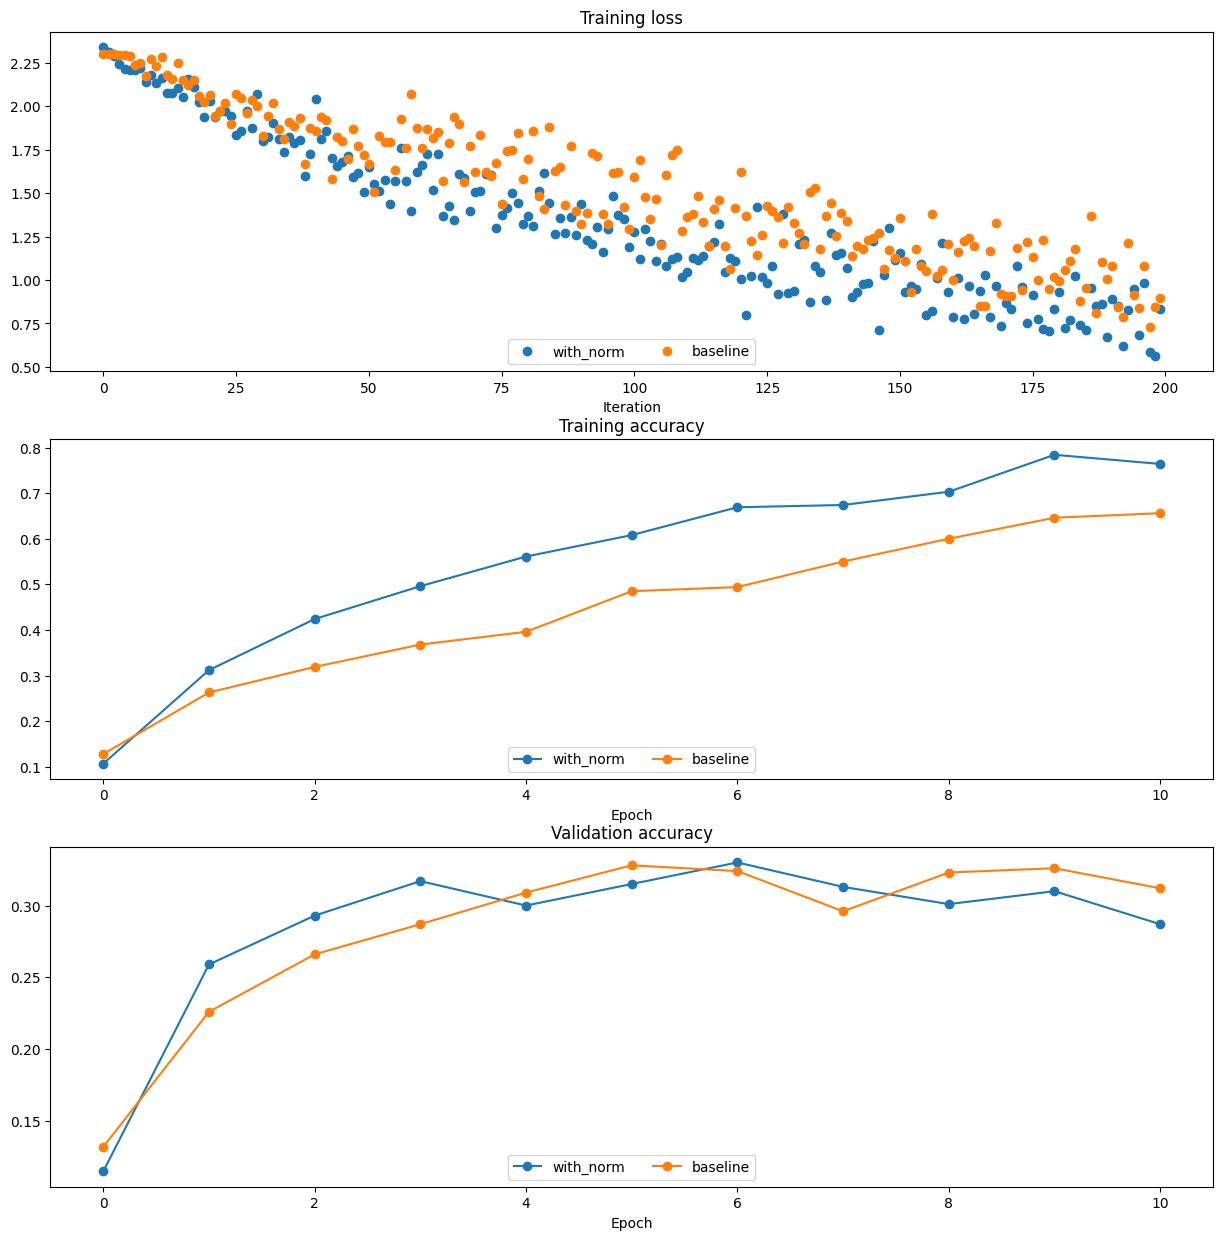

In [46]:
def plot_training_history(title, label, baseline, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
    bl_plot = plot_fn(baseline)
    num_bn = len(bn_plots)
    for i in range(num_bn):
        label='with_norm'
        if labels is not None:
            label += str(labels[i])
        plt.plot(bn_plots[i], bn_marker, label=label)
    label='baseline'
    if labels is not None:
        label += str(labels[0])
    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_bn+1)


plt.subplot(3, 1, 1)
plot_training_history('Training loss','Iteration', solver, [bn_solver], \
                      lambda x: x.loss_history, bl_marker='o', bn_marker='o')
plt.subplot(3, 1, 2)
plot_training_history('Training accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.train_acc_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history('Validation accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.val_acc_history, bl_marker='-o', bn_marker='-o')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Batch Normalization and Initialization
We will now run a small experiment to study the interaction of batch normalization and weight initialization.

The first cell will train eight-layer networks both with and without batch normalization using different scales for weight initialization. The second layer will plot training accuracy, validation set accuracy, and training loss as a function of the weight initialization scale.

In [47]:
np.random.seed(231)

# Try training a very deep net with batchnorm.
hidden_dims = [50, 50, 50, 50, 50, 50, 50]
num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers_ws = {}
solvers_ws = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
    print('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
    bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization='batchnorm')
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)

    bn_solver = Solver(bn_model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
    bn_solver.train()
    bn_solvers_ws[weight_scale] = bn_solver

    solver = Solver(model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
    solver.train()
    solvers_ws[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20


/tmp/ipython-input-1267229465.py:185: RuntimeWarning: divide by zero encountered in log
  correct_logprobs = -np.log(probs[np.arange(N), y])


Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


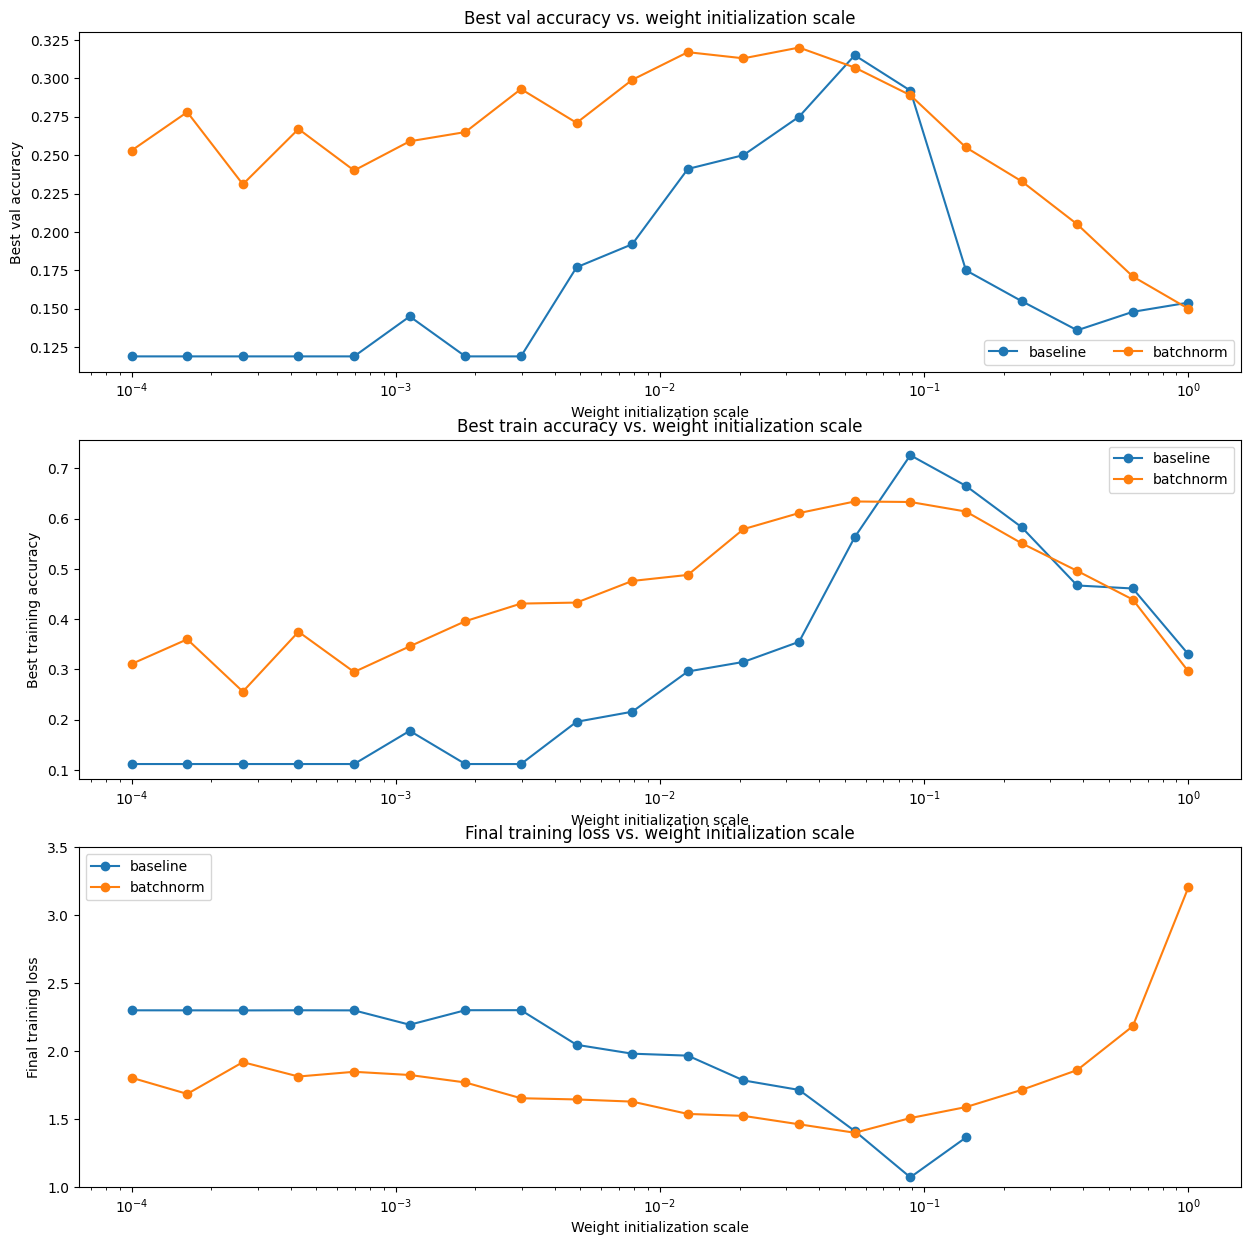

In [48]:
# Plot results of weight scale experiment.
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
  best_train_accs.append(max(solvers_ws[ws].train_acc_history))
  bn_best_train_accs.append(max(bn_solvers_ws[ws].train_acc_history))

  best_val_accs.append(max(solvers_ws[ws].val_acc_history))
  bn_best_val_accs.append(max(bn_solvers_ws[ws].val_acc_history))

  final_train_loss.append(np.mean(solvers_ws[ws].loss_history[-100:]))
  bn_final_train_loss.append(np.mean(bn_solvers_ws[ws].loss_history[-100:]))

plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs. weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs. weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs. weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()
plt.gca().set_ylim(1.0, 3.5)

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 1:
Describe the results of this experiment. How does the weight initialization scale affect models with/without batch normalization differently, and why?

## Answer:
[FILL THIS IN]


# Batch Normalization and Batch Size
We will now run a small experiment to study the interaction of batch normalization and batch size.

The first cell will train 6-layer networks both with and without batch normalization using different batch sizes. The second layer will plot training accuracy and validation set accuracy over time.

In [49]:
def run_batchsize_experiments(normalization_mode):
    np.random.seed(231)

    # Try training a very deep net with batchnorm.
    hidden_dims = [100, 100, 100, 100, 100]
    num_train = 1000
    small_data = {
      'X_train': data['X_train'][:num_train],
      'y_train': data['y_train'][:num_train],
      'X_val': data['X_val'],
      'y_val': data['y_val'],
    }
    n_epochs=10
    weight_scale = 2e-2
    batch_sizes = [5,10,50]
    lr = 10**(-3.5)
    solver_bsize = batch_sizes[0]

    print('No normalization: batch size = ',solver_bsize)
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)
    solver = Solver(model, small_data,
                    num_epochs=n_epochs, batch_size=solver_bsize,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    },
                    verbose=False)
    solver.train()

    bn_solvers = []
    for i in range(len(batch_sizes)):
        b_size=batch_sizes[i]
        print('Normalization: batch size = ',b_size)
        bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=normalization_mode)
        bn_solver = Solver(bn_model, small_data,
                        num_epochs=n_epochs, batch_size=b_size,
                        update_rule='adam',
                        optim_config={
                          'learning_rate': lr,
                        },
                        verbose=False)
        bn_solver.train()
        bn_solvers.append(bn_solver)

    return bn_solvers, solver, batch_sizes

batch_sizes = [5,10,50]
bn_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('batchnorm')

No normalization: batch size =  5
Normalization: batch size =  5
Normalization: batch size =  10
Normalization: batch size =  50


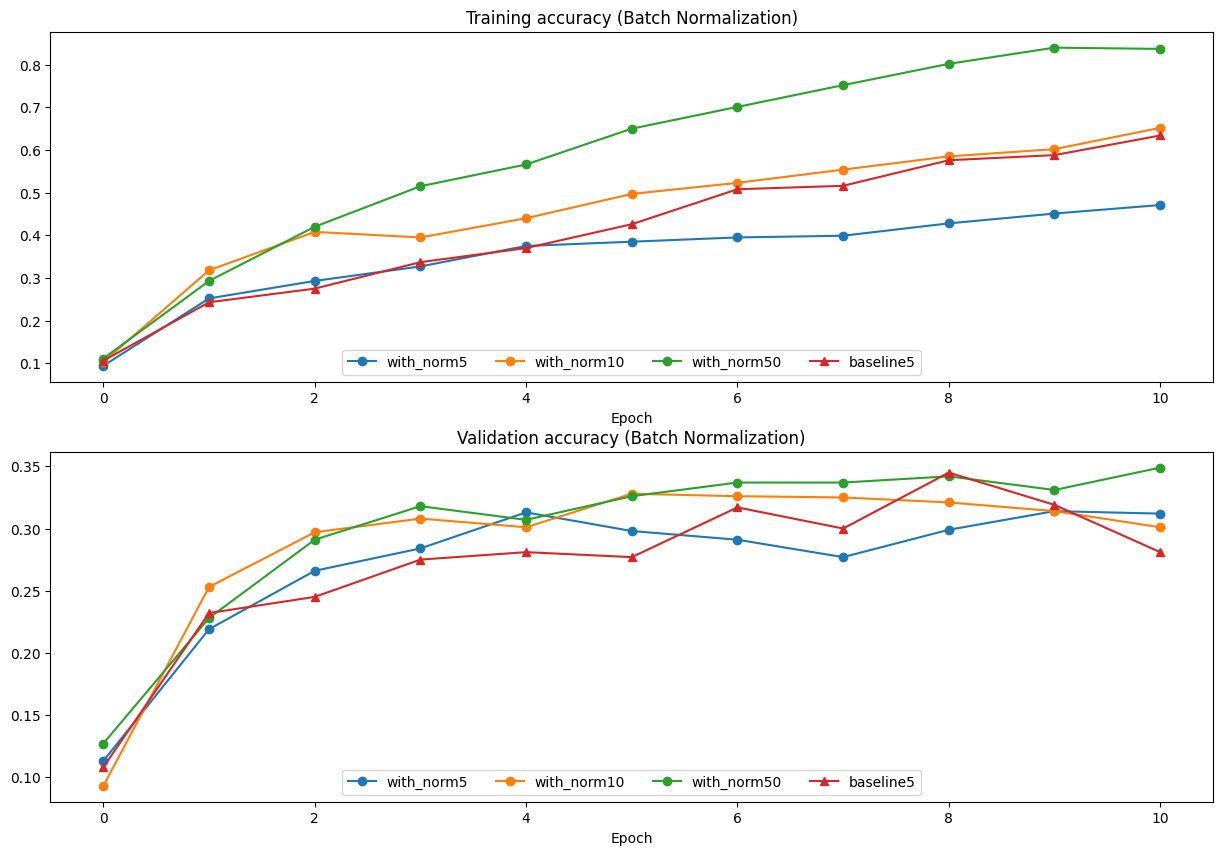

In [50]:
plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

## Inline Question 2:
Describe the results of this experiment. What does this imply about the relationship between batch normalization and batch size? Why is this relationship observed?

## Answer:
[FILL THIS IN]


# Layer Normalization
Batch normalization has proved to be effective in making networks easier to train, but the dependency on batch size makes it less useful in complex networks which have a cap on the input batch size due to hardware limitations.

Several alternatives to batch normalization have been proposed to mitigate this problem; one such technique is Layer Normalization [2]. Instead of normalizing over the batch, we normalize over the features. In other words, when using Layer Normalization, each feature vector corresponding to a single datapoint is normalized based on the sum of all terms within that feature vector.

[2] [Ba, Jimmy Lei, Jamie Ryan Kiros, and Geoffrey E. Hinton. "Layer Normalization." stat 1050 (2016): 21.](https://arxiv.org/pdf/1607.06450.pdf)

## Inline Question 3:
Which of these data preprocessing steps is analogous to batch normalization, and which is analogous to layer normalization?

1. Scaling each image in the dataset, so that the RGB channels for each row of pixels within an image sums up to 1.
2. Scaling each image in the dataset, so that the RGB channels for all pixels within an image sums up to 1.  
3. Subtracting the mean image of the dataset from each image in the dataset.
4. Setting all RGB values to either 0 or 1 depending on a given threshold.

## Answer:
[FILL THIS IN]


# Layer Normalization: Implementation

Now you'll implement layer normalization. This step should be relatively straightforward, as conceptually the implementation is almost identical to that of batch normalization. One significant difference though is that for layer normalization, we do not keep track of the moving moments, and the testing phase is identical to the training phase, where the mean and variance are directly calculated per datapoint.

Here's what you need to do:

* In `cs231n/layers.py`, implement the forward pass for layer normalization in the function `layernorm_forward`.

Run the cell below to check your results.
* In `cs231n/layers.py`, implement the backward pass for layer normalization in the function `layernorm_backward`.

Run the second cell below to check your results.
* Modify `cs231n/classifiers/fc_net.py` to add layer normalization to the `FullyConnectedNet`. When the `normalization` flag is set to `"layernorm"` in the constructor, you should insert a layer normalization layer before each ReLU nonlinearity.

Run the third cell below to run the batch size experiment on layer normalization.

In [51]:
# Check the training-time forward pass by checking means and variances
# of features both before and after layer normalization.

# Simulate the forward pass for a two-layer network.
np.random.seed(231)
N, D1, D2, D3 =4, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before layer normalization:')
print_mean_std(a,axis=1)

gamma = np.ones(D3)
beta = np.zeros(D3)

# Means should be close to zero and stds close to one.
print('After layer normalization (gamma=1, beta=0)')
a_norm, _ = layernorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=1)

gamma = np.asarray([3.0,3.0,3.0])
beta = np.asarray([5.0,5.0,5.0])

# Now means should be close to beta and stds close to gamma.
print('After layer normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = layernorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=1)

Before layer normalization:
  means: [-59.06673243 -47.60782686 -43.31137368 -26.40991744]
  stds:  [10.07429373 28.39478981 35.28360729  4.01831507]

After layer normalization (gamma=1, beta=0)
  means: [ 4.81096644e-16 -7.40148683e-17  2.22044605e-16 -5.92118946e-16]
  stds:  [0.99999995 0.99999999 1.         0.99999969]

After layer normalization (gamma= [3. 3. 3.] , beta= [5. 5. 5.] )
  means: [5. 5. 5. 5.]
  stds:  [2.99999985 2.99999998 2.99999999 2.99999907]



In [52]:
# Gradient check batchnorm backward pass.
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

ln_param = {}
fx = lambda x: layernorm_forward(x, gamma, beta, ln_param)[0]
fg = lambda a: layernorm_forward(x, a, beta, ln_param)[0]
fb = lambda b: layernorm_forward(x, gamma, b, ln_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = layernorm_forward(x, gamma, beta, ln_param)
dx, dgamma, dbeta = layernorm_backward(dout, cache)

# You should expect to see relative errors between 1e-12 and 1e-8.
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.4336160411201157e-09
dgamma error:  4.519489546032799e-12
dbeta error:  2.276445013433725e-12


# Layer Normalization and Batch Size

We will now run the previous batch size experiment with layer normalization instead of batch normalization. Compared to the previous experiment, you should see a markedly smaller influence of batch size on the training history!

No normalization: batch size =  5
Normalization: batch size =  5
Normalization: batch size =  10
Normalization: batch size =  50


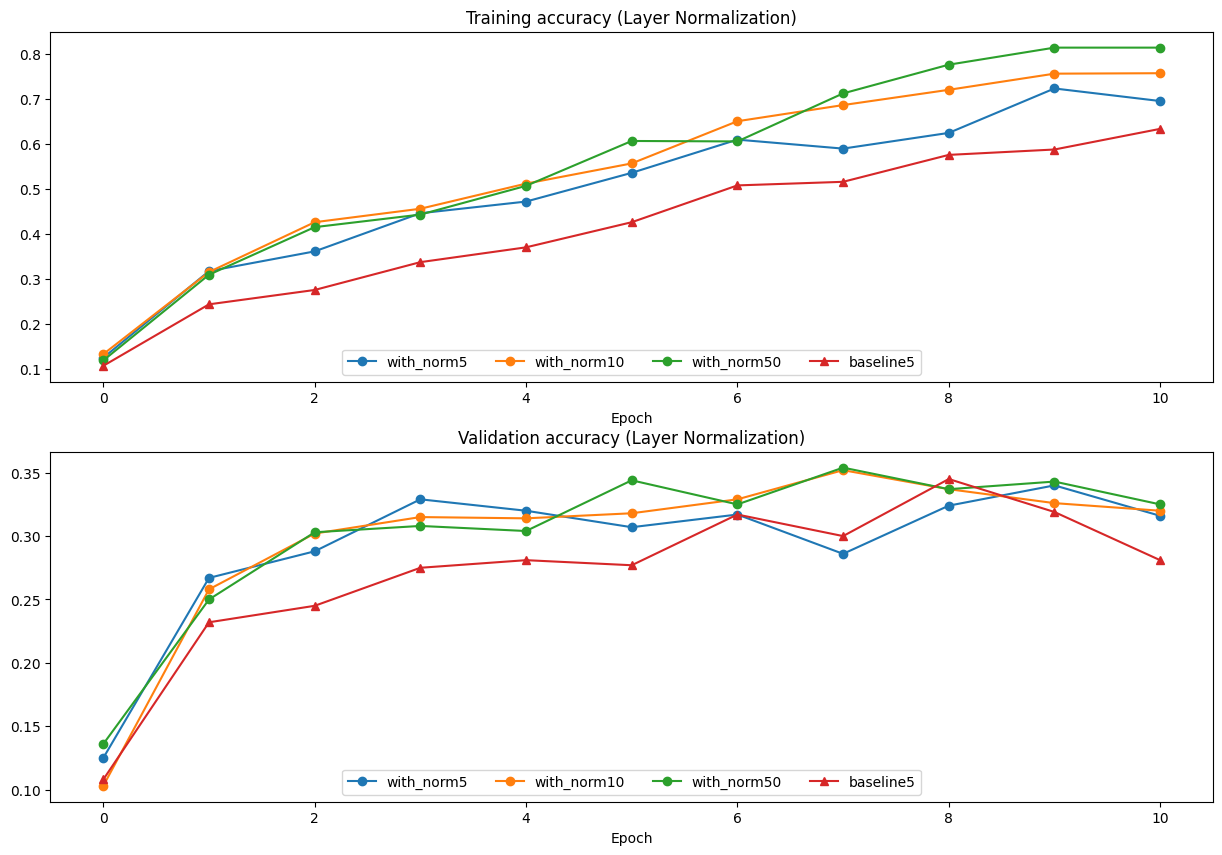

In [53]:
ln_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('layernorm')

plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Layer Normalization)','Epoch', solver_bsize, ln_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Layer Normalization)','Epoch', solver_bsize, ln_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

## Inline Question 4:
When is layer normalization likely to not work well, and why?

1. Using it in a very deep network
2. Having a very small dimension of features
3. Having a high regularization term


## Answer:
[FILL THIS IN]
